In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
epochs = 20

In [3]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

In [5]:
# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [6]:
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

In [7]:
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

In [8]:
decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

In [9]:
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

In [10]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

In [11]:
# Compute VAE loss
xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 1)    5           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   320         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

C:\Users\Prakalp.Somawanshi\Miniconda3\envs\kerasencoder\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output conv2d_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to conv2d_5.
  'be expecting any data to be passed to {0}.'.format(name))


In [12]:
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

x_train.shape: (60000, 28, 28, 1)


In [13]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 26s - loss: 178.5957 - val_loss: 161.6504
Epoch 2/20
 - 24s - loss: 155.9697 - val_loss: 152.6099
Epoch 3/20
 - 24s - loss: 150.4598 - val_loss: 151.5158
Epoch 4/20
 - 25s - loss: 147.3635 - val_loss: 144.9794
Epoch 5/20
 - 26s - loss: 145.4254 - val_loss: 148.0299
Epoch 6/20
 - 26s - loss: 144.1566 - val_loss: 143.4093
Epoch 7/20
 - 26s - loss: 143.1743 - val_loss: 142.6420
Epoch 8/20
 - 26s - loss: 142.1977 - val_loss: 142.6964
Epoch 9/20
 - 27s - loss: 141.5128 - val_loss: 142.4973
Epoch 10/20
 - 27s - loss: 140.9276 - val_loss: 141.6797
Epoch 11/20
 - 27s - loss: 140.3339 - val_loss: 141.9678
Epoch 12/20
 - 26s - loss: 139.8877 - val_loss: 140.3618
Epoch 13/20
 - 27s - loss: 139.4933 - val_loss: 140.2914
Epoch 14/20
 - 27s - loss: 139.2006 - val_loss: 140.0983
Epoch 15/20
 - 27s - loss: 138.8846 - val_loss: 140.1591
Epoch 16/20
 - 27s - loss: 138.5228 - val_loss: 140.3035
Epoch 17/20
 - 27s - loss: 138.2159 - val_loss:

In [14]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

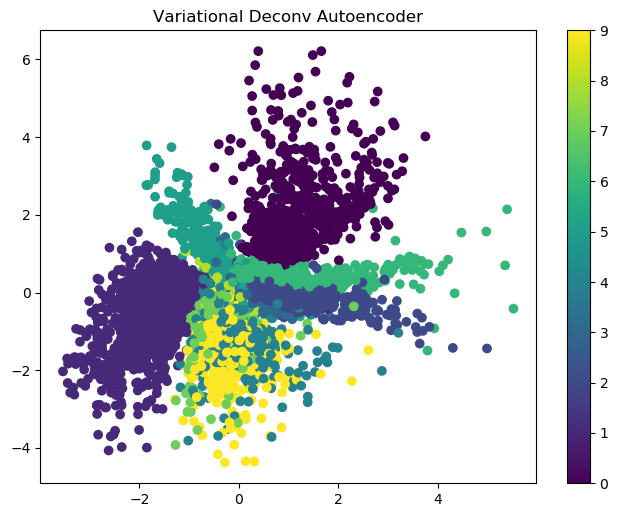

In [15]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.title('Variational Deconv Autoencoder')
plt.colorbar()
plt.show()

In [21]:
print(x_test_encoded)
print(len(x_test_encoded))

[[-0.1636473  -0.3026634 ]
 [ 1.1073387  -0.2649258 ]
 [-2.1295588  -0.38615268]
 ...
 [-0.40930358 -0.28702685]
 [-1.1259108   1.6835215 ]
 [ 0.39388946  0.5218096 ]]
10000


In [16]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

In [17]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

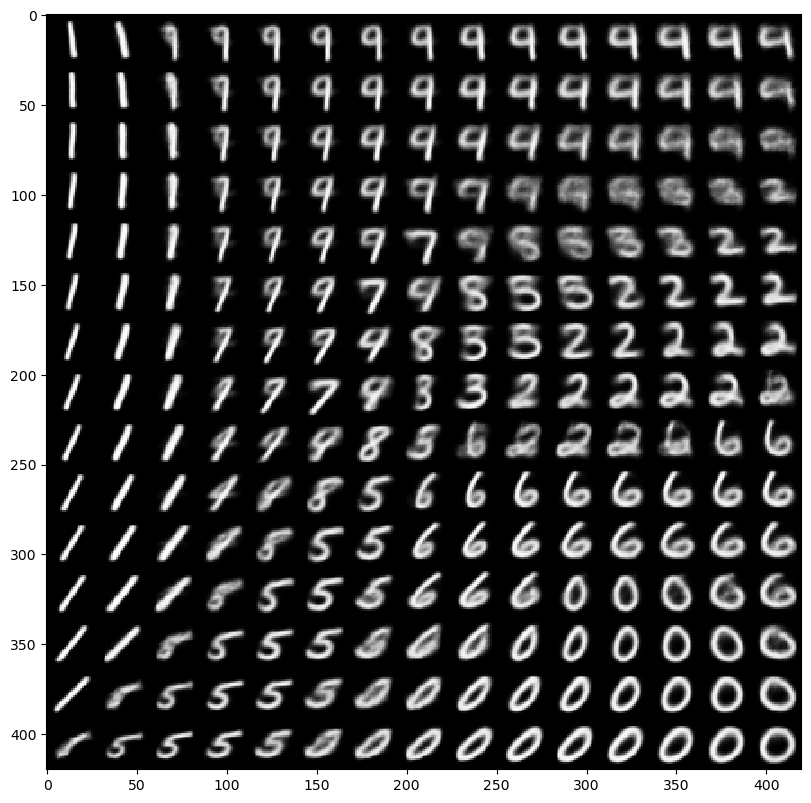

In [18]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(figure, cmap='Greys_r')
plt.show()

K.clear_session()